# Topic modelling – blockchain - related articles

# Session setup

## Libraries

In [11]:
# basic operations
import os
import glob
import re
import logging
import time
import pickle

# utilities
from pprint import pprint as pp

# data analysis/management/manipulation
import numpy as np
import pandas as pd
import sklearn

# text analysis
import gensim
from gensim.models import LdaModel, ldamodel
from gensim.models import LsiModel, lsimodel
from gensim.models import Phrases
from gensim.models import CoherenceModel  
from gensim.corpora import Dictionary
from gensim.similarities import MatrixSimilarity
'''
Uncomment the next two lines of code if you don't have a copy of the
Mallet software installed in your machine
'''
# ! wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip # * updated if needed *
# ! unzip mallet-2.0.8.zip
MALLET_PATH = 'mallet-2.0.8/bin/mallet'
import spacy
import en_core_web_lg

# multivariate analysis
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

# distance metrics
from scipy.spatial.distance import cosine

# visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pyLDAvis
import pyLDAvis.gensim # directly import the module `gensim'!

## Options for dumping outcome to the screen

In [12]:
# data vis
%matplotlib inline

# send output to the screen
LINE = ''.join(['\n', 79 * '~', '\n'])

## Basic info about the notebook/session

In [13]:
# check libraries
print(' | '.join(['spaCy Version: %s' % (spacy.__version__),
                  'Gensim Version: %s' % (gensim.__version__),]),
      end=LINE)

# coding style
print('Coding style as per PEP8', '', end=LINE)

spaCy Version: 2.1.4 | Gensim Version: 3.7.3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Coding style as per PEP8 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# Read data

In [14]:
# params
# SRV = '/Users/simone'
SRV = '/media/simone/data'
PATH = 'Dropbox/dataProjects/code/AI/pressRelease/factiva'
FOLDER = '002787c0-99a7-11e9-90f7-f8b156d0a52b'
FILE = 'ai_articles.csv'
DF = pd.read_csv(os.path.join(SRV, PATH, FOLDER, FILE),
                 encoding='ISO-8859-1')

# Logging Gensim's output

In [15]:
LOG_FILE = os.path.join(SRV, PATH, FOLDER, 'log_%s.txt' % time.time())

logging.basicConfig(filename=LOG_FILE,
                    format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO)

# Basic data cleaning

In [16]:
# remove returns
DF.loc[:, 'text'] = DF['text'].str.replace('\n', '')

# remove copyright details
DF.loc[:, 'text'] = DF['text'].str.split('©').str.get(0)

# list of docs published in 2017
TEXT17 = DF.loc[(DF['year'] == 2017) & (DF['text'].notnull()),
              'text']
DOCS17 = [text.strip().lower() for text in TEXT17]

# list of docs published in 2018
TEXT18 = DF.loc[(DF['year'] == 2018) & (DF['text'].notnull()),
              'text']
DOCS18 = [text.strip().lower() for text in TEXT18]

# Pass documents through spaCy's `nlp` pipeline

## Load language model

In [17]:
# load spaCy model 'web_lg'
nlp = en_core_web_lg.load()

## Expand on spaCy's stopwords

In [18]:
# custom stopwords
MY_STOPWORDS = []

# expand on spaCy's stopwords 
for stopword in MY_STOPWORDS:
    nlp.vocab[stopword].is_stop = True

# 2017 Articles

## Tokenize text

In [19]:
# filter text
DOCS_TOKENS, TMP_TOKENS = [], []

for doc in DOCS17:
    TMP_TOKENS = [token.lemma_ for token in nlp(doc)
                  if not token.is_stop and not token.is_punct
                  and not token.like_num]
    DOCS_TOKENS.append(TMP_TOKENS)
    TMP_TOKENS = []

## Take into account bi- and tri-grams

In [20]:
# get rid of common terms
COMMON_TERMS = [u'of', u'with', u'without', u'and', u'or', u'the', u'a',
                u'not', 'be', u'to', u'this', u'who', u'in']

# find phrases
BIGRAM = Phrases(DOCS_TOKENS,
                 min_count=50,
                 threshold=5,
                 max_vocab_size=50000,
                 common_terms=COMMON_TERMS)

TRIGRAM = Phrases(BIGRAM[DOCS_TOKENS],
                  min_count=50,
                  threshold=5,
                  max_vocab_size=50000,
                  common_terms=COMMON_TERMS)

# uncomment if bi-grammed, tokenized document is preferred
# DOCS_PHRASED = [BIGRAM[line] for line in DOCS_TOKENS]
DOCS_PHRASED = [TRIGRAM[BIGRAM[line]] for line in DOCS_TOKENS]

# check nlp pipeline
print('',
      'Published article:', DOCS17[0],
      'Tokenized article:', DOCS_TOKENS[0],
      'Tri-grammed tokenised aticle:', DOCS_PHRASED[0],
      sep=LINE, end=LINE)


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Published article:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
as companies scale their use of big data, the move brings a lot of questions. does it require new architecture? does it require new platforms? the wall street journal's jay greene discussed the topic with richard sherlund, managing director and chairman, software investment banking, at barclays. the discussion covered everything from going beyond big data that looks to the past to newer applications that will be able to learn and make predictions.edited excerpts follow.mr. greene: you have this idea that we are at the precipice of a big change in the way systems architecture is set up and that many cios are unprepared.mr. sherlund: i think the internet of things has enabled industrial companies to start thinking about the need to move to big data.because in the past you really couldn't aggregate big data. it 

# Topic modeling

## Model building

### Text transformation

In [21]:
# create dictionary and text corpus
'''
overriding these transformations breaks reproducibility
'''
DICT = Dictionary(DOCS_PHRASED)
CORPUS = [DICT.doc2bow(doc) for doc in DOCS_PHRASED]

### Mallet's implementation of LDA algorithm (using Gibbs sampling)

In [ ]:
'''
Based on Gardner et al's LQ paper, we expect to see
29 distinctive topics circa
'''
N_TOPICS = 10
LDA_MALLET = gensim.models.wrappers.LdaMallet(MALLET_PATH,
                                              corpus=CORPUS,
                                              num_topics=N_TOPICS,
                                              id2word=DICT,
                                              random_seed=123)
LDA_MALLET.print_topics(num_topics=N_TOPICS, num_words=5)

/home/simone/py3_venvs/nlp/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


##  Model evaluation

### Get range of coherence values as the number of retained topics change

In [24]:
# define function
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    -----------
    dictionary : Gensim dictionary
    corpus     : Gensim corpus
    texts      : List of input texts
    limit      : Max number of topics

    Returns:
    --------
    model_list       : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model
                       with respective number of topics
    """
    coherence_values = []
    model_list = []
    mallet_path = MALLET_PATH
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path,
                                                 corpus=corpus,
                                                 num_topics=num_topics,
                                                 id2word=dictionary,
                                                 random_seed=123)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model,
                                        texts=texts,
                                        dictionary=dictionary,
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [25]:
# collect coherence scores as the number of retained topics change
LIMIT, START, STEP = 16, 2, 2
MODEL_LIST, COHER_VALS = compute_coherence_values(dictionary=DICT,
                                                  corpus=CORPUS,
                                                  texts=DOCS_PHRASED,
                                                  start=START,
                                                  limit=LIMIT,
                                                  step=STEP)

/home/simone/py3_venvs/nlp/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


FileNotFoundError: [Errno 2] No such file or directory: '/media/simone/data/Dropbox/dataProjects/code/AI/pressRelease/factiva/exhibits/appxB/B_0.pdf'

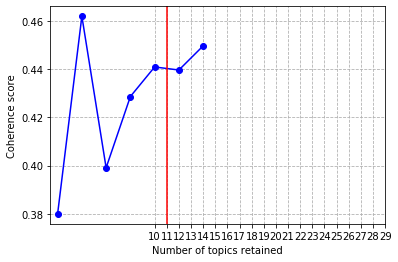

In [26]:
# plot collected coherence scores data

# data series
X = range(START, LIMIT, STEP)
Y = COHER_VALS

# create figure
FIG = plt.figure(figsize=(6, 4))
AX = FIG.add_subplot(1, 1, 1)

# plot data
AX.plot(X, Y, marker='o', color='b', ls='-')

# axes
AX.set_xlabel("Number of topics retained")
AX.set_ylabel("Coherence score")
AX.set_xticks(np.arange(10, 30, 1))

# reference line
AX.axvline(x=11, ymin=0, ymax=1, color='r')

# grid
AX.grid(True, ls='--')

# save plot to file
SRV, PATH = SRV, PATH
FOLDER = 'exhibits'
FILE = 'B_0.pdf'
plt.savefig(os.path.join(SRV, PATH, FOLDER, FILE),
            transparent=True,
            bbox_inches='tight',
            pad_inches=0)

plt.show()

In [27]:
# suggested number of topics to retain -- see above
N_TOPICS = 4

# model estimation
LDA_MALLET = gensim.models.wrappers.LdaMallet(MALLET_PATH,
                                              corpus=CORPUS,
                                              num_topics=N_TOPICS,
                                              id2word=DICT,
                                              random_seed=123)

# print results
LDA_MALLET.print_topics(num_topics=N_TOPICS, num_words=10)

/home/simone/py3_venvs/nlp/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


[(0,
  '0.037*"bitcoin" + 0.013*"exchange" + 0.011*"currency" + 0.010*"\x1c" + 0.010*"\x1d" + 0.010*"market" + 0.010*"$" + 0.009*"digital" + 0.009*"trade" + 0.009*"price"'),
 (1,
  '0.020*"fund" + 0.020*"$" + 0.017*"company" + 0.012*"year" + 0.011*"investment" + 0.011*"investor" + 0.010*"firm" + 0.008*"market" + 0.008*"stock" + 0.007*"share"'),
 (2,
  '0.018*"bank" + 0.013*"rate" + 0.011*"year" + 0.008*"central" + 0.007*"financial" + 0.007*"market" + 0.006*"time" + 0.006*"risk" + 0.006*"tax" + 0.006*"economy"'),
 (3,
  '0.020*"bank" + 0.015*"financial" + 0.013*"mr" + 0.008*"rule" + 0.007*"regulator" + 0.006*"u.s" + 0.005*"trump" + 0.005*"sec" + 0.005*"regulation" + 0.004*"article"')]

### Result visualization with pyLDAvis

### Copy the training model weights from `Mallet` to `Gensim`

In [ ]:
# translate topic modeling outcome
LDA_MALLET_G = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(LDA_MALLET)

In [ ]:
# ignore warnings coming from pyLDAvis
import warnings
warnings.filterwarnings('ignore')

# visualizing the outcome of the retained model -- this takes time
pyLDAvis.enable_notebook()
DATA_VIS = pyLDAvis.gensim.prepare(LDA_MALLET_G, CORPUS, DICT, sort_topics=False)
DATA_VIS

In [ ]:
# save pyLDAvis data to json file
pyLDAvis.save_json(DATA_VIS, 'topic_modelling_vis.json')